In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('../src')

import numpy as np
from utils import adata_train

In [8]:
from tqdm import tqdm
import pandas as pd

import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

2024-09-02 21:33:02.057542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 21:33:02.372503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 21:33:02.559197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 21:33:02.615690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 21:33:02.881321: I tensorflow/core/platform/cpu_feature_guar

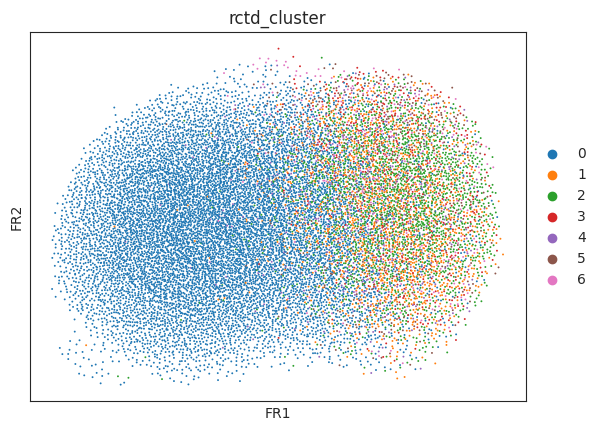

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc 

sc.tl.pca(adata_train)
sc.pp.neighbors(adata_train)
sc.tl.draw_graph(adata_train, layout='fa')
sc.pl.draw_graph(adata_train, color='rctd_cluster')

In [12]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=15, 
    learning_rate=7e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='zeros',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
)

so.cluster_column_name = 'rctd_cluster'

None
🌍️ Generating spatial 64x64 maps...


In [13]:
so.embedding_name = 'X_draw_graph_fr'
so.embedding = so.adata.obsm['X_draw_graph_fr']
so.cluster_column_name = 'rctd_cluster'

In [14]:
from celloracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(oracle_object=so)

In [15]:
# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

62


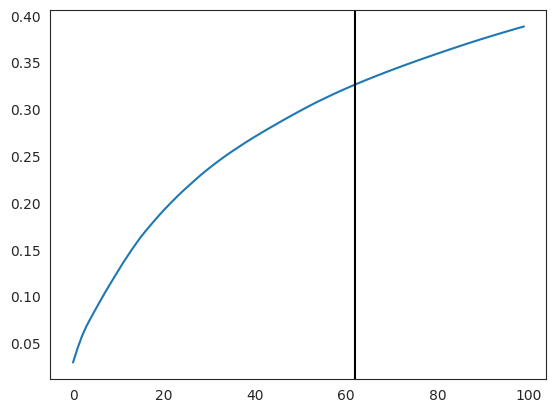

In [16]:
# Select important PCs
plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [17]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :15870
Auto-selected k is :396


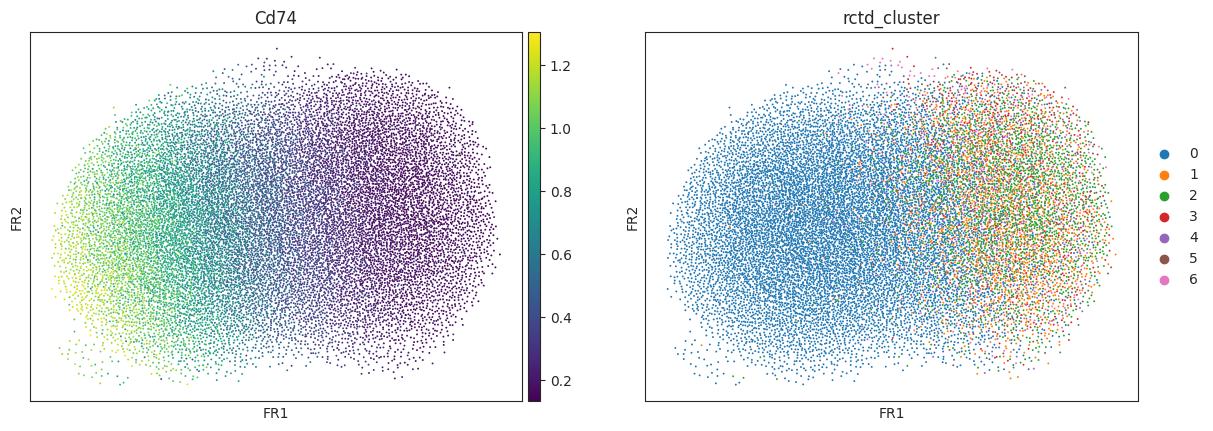

In [18]:
goi = "Cd74"
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

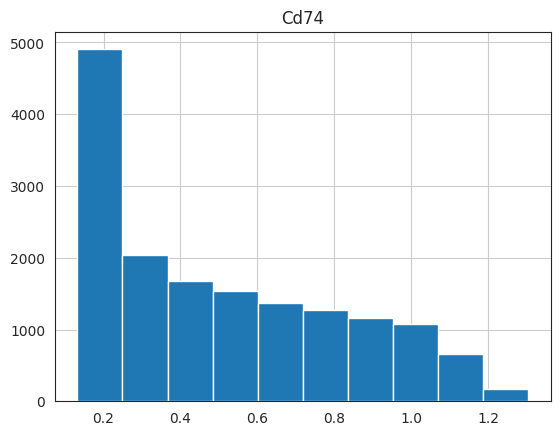

In [19]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [20]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [25]:
# coef_matrix = so.get_coef_matrix(so.adata.copy())
# perturbed_matrix = so.perturb(so.adata.to_df().values, coef_matrix, n_propagation=3)

# so.adata.layers['delta_X'] = so.adata.layers['imputed_count'] - perturbed_matrix
# so.adata.layers['delta_X'].shape

so.simulate_shift(perturb_condition={'Cd74': 0.0})

Running simulation 3/3: 100%|██████████| 15870/15870 [00:44<00:00, 358.80it/s] 


In [26]:
so.estimate_transition_prob()

In [27]:
so.calculate_embedding_shift(sigma_corr=0.05)

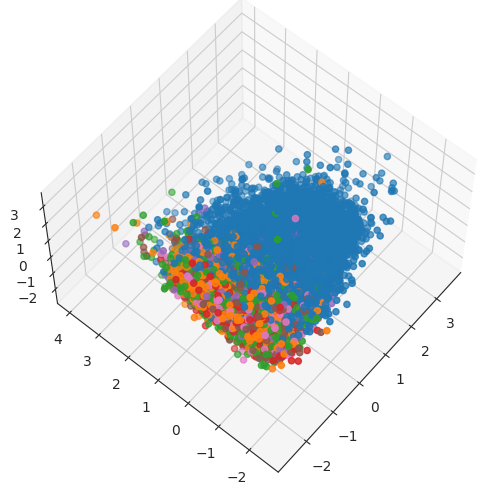

In [28]:
so.plot_pca()

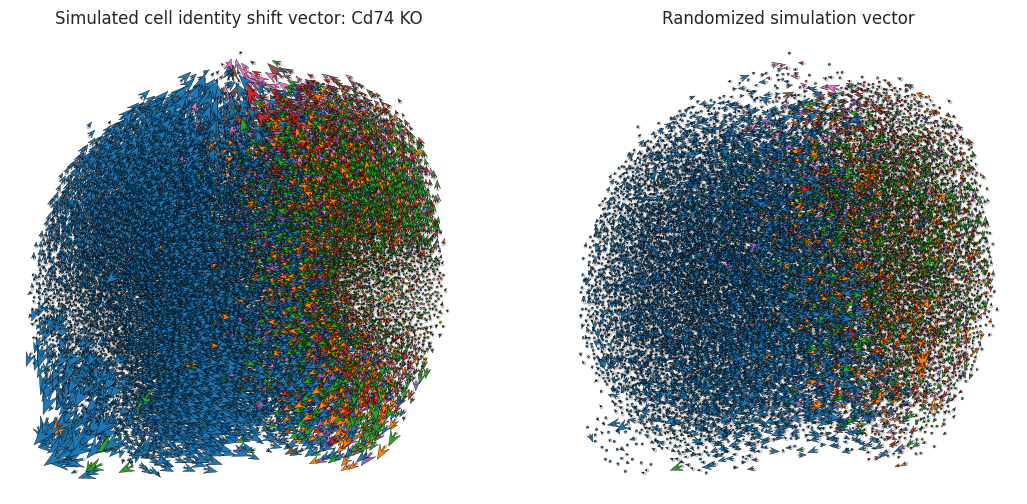

In [29]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [30]:
# n_grid = 40 is a good starting value.
n_grid = 40
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

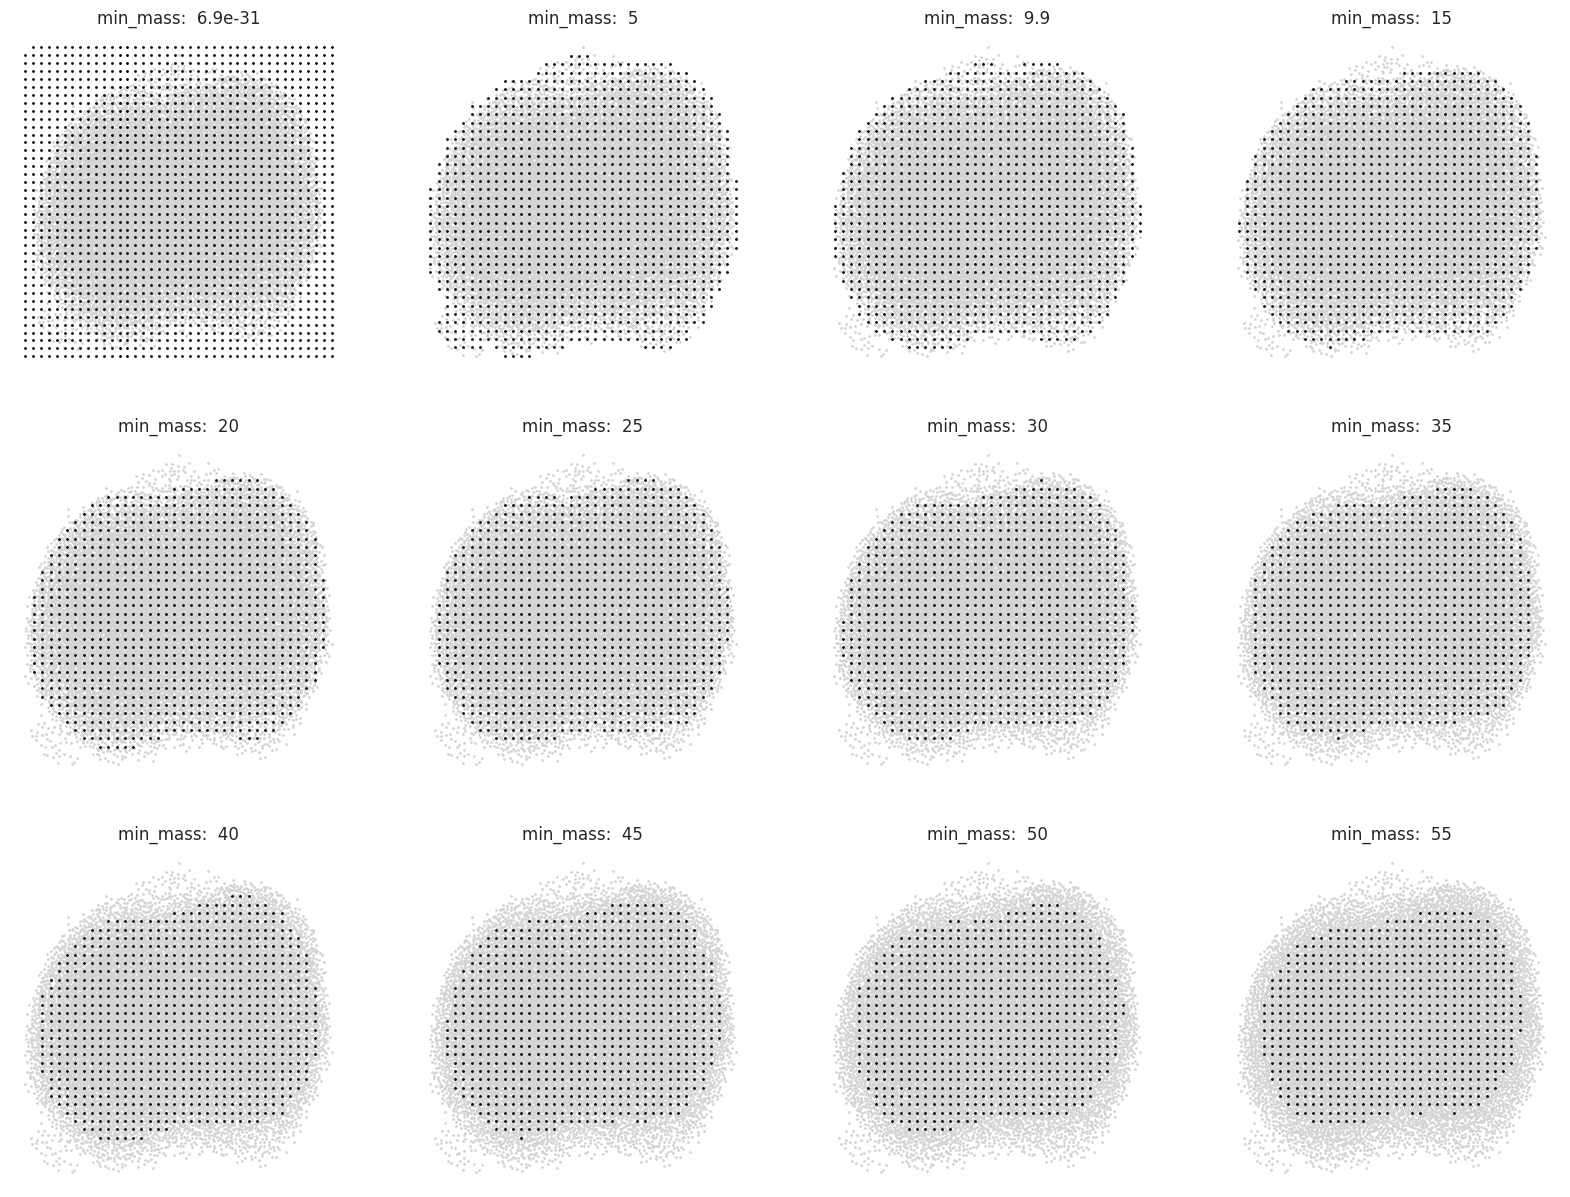

In [31]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

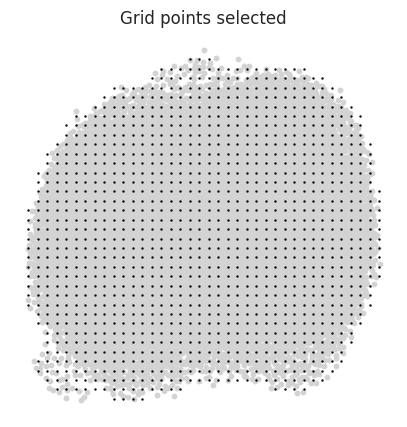

In [32]:
min_mass = 4.2
so.calculate_mass_filter(min_mass=min_mass, plot=True)

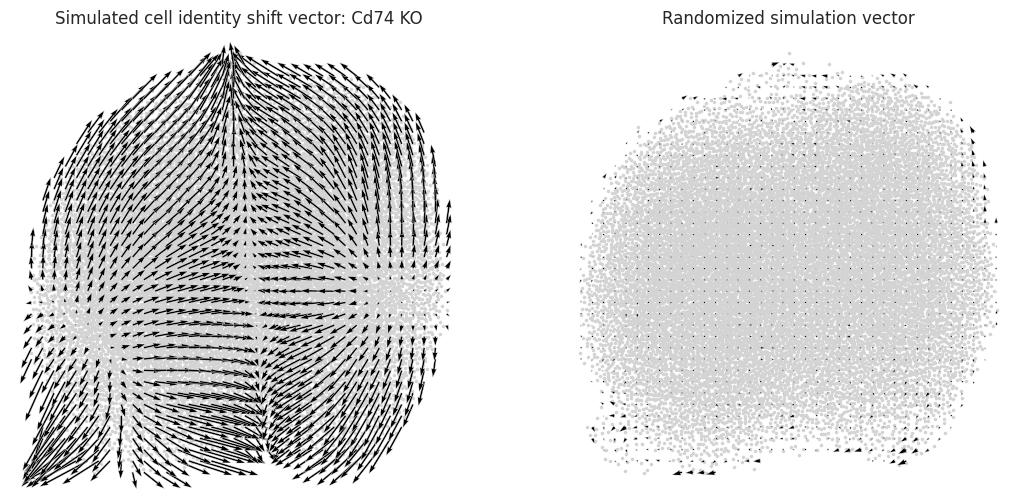

In [33]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

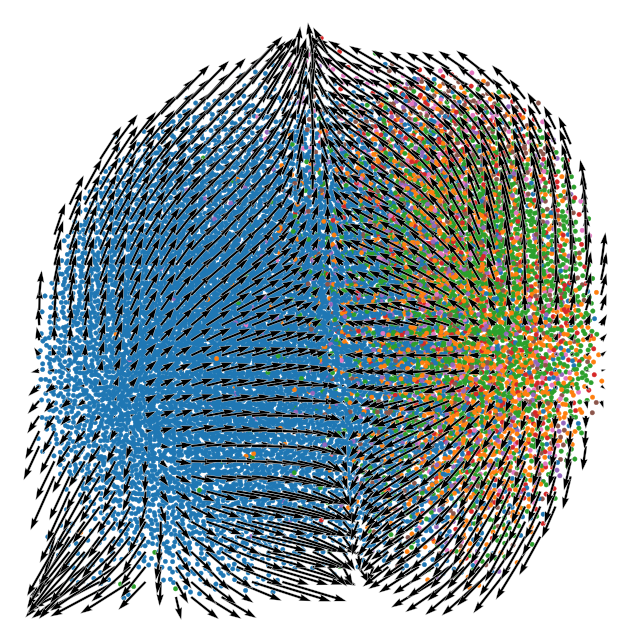

In [34]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [37]:
so.beta_dict.keys()

dict_keys([])

In [39]:
so.adata.to_df().shape

(15870, 2643)

In [40]:
so._get_spatial_betas_dict()

Estimating betas globally: 0it [00:00, ?it/s]


{}